# Inference acceleration of T5 for large batch size / long sequence length

Accelerating autoregressive models for large batch and long sequence length is not easy.

## The challenge

In most situations, performing inference with ONNX Runtime or ``TensorRT`` usually bring large improvement over Pytorch implementations.
It's very true with `transformer` based models.

The main reason is that these tools will perform kernel fusions (merging several operations into a single one) and therefore reduce the number of memory bounded operations.
In the very specific case of autoregressive languages, things are a bit more complicated.

On most Pytorch implementations of these models, there is a `cache` of K and V values.
Let's remind us that in the self-attention block, each token is projected on 3 matrices called Query, Key, and Value.
Then, those projections will be used to compute a representation of each token which takes into account all the other tokens of the sequence.

As autoregressive models generate the sequence one token at a time, they recompute final representation of all past tokens for each new token to generate.
Because each token can only attend to the past, the result of these computations never changes; therefore one easy trick is to just memorize them and reuse them later, avoiding lots of computation.

Out of the box, the cache mechanism can't be exported to ONNX from Hugging Face models (and all other Pytorch implementations we are aware of).
The reason is that those models are not `torchscript` compliant (it requires Pytorch code to follow some restrictive rules).
Because of that, ONNX export is done through `tracing` which erase any control flow (including the `If` instruction to enable or not a cache).

## Existing solutions

Some projects have tried to work around that:
* [TensorRT](https://developer.nvidia.com/blog/optimizing-t5-and-gpt-2-for-real-time-inference-with-`TensorRT`/), which targets `GPU`, heavily optimizes the computation graph, making inference very fast even if it has to redo computation again and again. As many have already found ([1](https://github.com/NVIDIA/TensorRT/issues/1807), [2](https://github.com/NVIDIA/TensorRT/issues/1642), [3](https://github.com/NVIDIA/TensorRT/issues/1799), [4](https://github.com/NVIDIA/TensorRT/issues/1845), ...), this approach doesn't scale to many real-life scenarios (beam search and/or long sequence length);
* [FastT5](https://github.com/Ki6an/fastT5), which targets `CPU`, exports 2 versions of the decoder, one with cache and one without. You need the `no cache` version to compute the first token and the first `past state` tensors (aka the cached tensors), and for all the other tokens you use the `cache` version of the computation graph. Basically, it makes the memory foot print 2 times bigger as all weights are duplicated. As generative models tend to be huge, they work around the memory issue by using dynamic `int-8` quantization (which is 2 times smaller than FP16), the final memory foot print is now the same as FP16. This is not perfect for 2 reasons, dynamic quantization only work on `CPU` and they are slow on matrix multiplication even on quantized models, plus according to several reports ([1](https://github.com/huggingface/transformers/issues/2466#issuecomment-572781378), [2](https://github.com/huggingface/transformers/issues/2466#issuecomment-982710520), and [here](https://github.com/microsoft/onnxruntime/issues/6549#issuecomment-1016948837) you can find a report in the `GPT-2` context from a Microsoft engineer: "*int8 quantization are not recommended due to accuracy loss*"), dynamic quantization degrades significantly generative model output, to a point where it may make them useless.
* [FasterTransformer](https://github.com/NVIDIA/FasterTransformer/blob/main/docs/t5_guide.md#translation-process) targets GPU and is a mix of Pytorch and CUDA/C++ dedicated code. The performance boost is huge on T5 (close to 10X) but it may significantly decrease the accuracy of the model ([here](https://github.com/NVIDIA/FasterTransformer/blob/main/docs/t5_guide.md#translation-process) when sampling is enabled, it reduces BLEU score of translation task by 8 points!). It may be a good idea to read the [objectives of the project](https://github.com/NVIDIA/FasterTransformer/issues/211#issuecomment-1093495810): to make it short, innovations implemented in this project will be included in TensorRT at some point, where it will be highly tested to provide accurate results.



## Our solution

Our solution to make autoregressive `transformer` based models several times faster than Hugging Face Pytorch implementation (the base line) is based on 3 key ingredients:

* storing 2 computation graph in a single ONNX file: this let us have both cache and no cache support without having any duplicated weights,
* `zero copy` to retrieve output from Onnx Runtime: we built over our past work to connect in the most efficient way `Pytorch` tensors (used in the decoding part) and Onnx Runtime. Our previous work was to avoid host <-> `GPU` tensor copy, but it still required a `GPU` <-> `GPU`. It is now part of the official Onnx Runtime documentation (apparently [thanks of our project](https://github.com/microsoft/onnxruntime/pull/10651)!). This time we found out a way to directly expose the internal state of Onnx Runtime through a `Pytorch` tensor in zero copy way. Combined with cache mechanism, this is responsible for most of the speedup we have obtained.
* a generic tool to convert any model (whatever the architecture) to `FP16` without any risk of having out of range values: `FP16` is still the way to reduce memory footprint of a model. The main issue is that some nodes may output values outside of FP16 range, resulting in `NaN` output. We have built a tool which detect those nodes so we can keep their precision in `FP32`. It's quite important to reduce memory footprint of these models, not just because they tend to be huge, but also because past states can be even bigger than the weights of the model themselves, and you prefer to store them as FP16 too.

## Results

As demonstrated at the end of this notebook, **we are able to provide a X2 speedup** whatever the batch size, the sequence length or the model size (we have tested our approach on T5 up to 3 billions of parameters). Of course, the speedup on small sequence length / batch size is even bigger.


Unlike our other works, `TensorRT` has not been used as we have found a limitation in the way it manages condition flow (output shapes of subgraphs should be fixed). We are looking for a solution to this issue as we think `TensorRT` is perfectly adapted to the next round of optimizations of autoregressive models based on `transformer` architecture. Integration of this work in Triton will be done when `TensorRT` will be fixed.

In [1]:
! nvidia-smi

Sun May  8 01:25:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0  On |                  N/A |
| 40%   44C    P8    40W / 350W |    169MiB / 24576MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import json
from time import time
from typing import Callable, Dict, Optional, List
import matplotlib.pylab as plt
from onnxruntime import IOBinding
import numpy as np
import onnx
import torch
from onnx import GraphProto, ModelProto, helper
from torch.nn import Linear
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, PretrainedConfig, T5ForConditionalGeneration, TensorType
from transformers.generation_utils import GenerationMixin
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions, Seq2SeqLMOutput
from transformers.models.t5.modeling_t5 import T5Stack
from nvtx import nvtx
from copy import copy

from transformer_deploy.backends.ort_utils import create_model_for_provider, inference_onnx_binding
from transformer_deploy.backends.pytorch_utils import convert_to_onnx

# Loading Hugging Face model / tokenizer

We use a specific branch of OnnxRuntime with a better management of if/else/then ONNX node:

```shell
git clone --recursive https://github.com/Microsoft/onnxruntime
cd onnxruntime
git fetch origin hari/location_plan_implicit_inputs
git checkout -b hari/location_plan_implicit_inputs FETCH_HEAD
CUDACXX=/usr/local/cuda-11.4/bin/nvcc ./build.sh \
    --config Release \
    --build_wheel \
    --parallel \
    --use_cuda \
    --cuda_home /usr/local/cuda-11.4 \
    --cudnn_home /usr/lib/x86_
    -linux-gnu/ \
    --skip_test
```

> to clear previous compilation, delete content of `./build` folder

In [3]:
model_name = "t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
input_ids: torch.Tensor = tokenizer(
    "translate English to French: This model is now very fast!", return_tensors=TensorType.PYTORCH
).input_ids
input_ids = input_ids.to("cuda")
model: T5ForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model = model.eval()
model = model.to("cuda")
model.config.use_cache = True
out_enc: BaseModelOutputWithPastAndCrossAttentions = model.encoder(input_ids=input_ids)
out_full: Seq2SeqLMOutput = model(input_ids=input_ids, decoder_input_ids=input_ids)
num_layers = model.config.num_layers


def are_equal(a: torch.Tensor, b: torch.Tensor, atol: float = 5e-1) -> None:
    assert np.allclose(a=a.detach().cpu().numpy(), b=b.detach().cpu().numpy(), atol=atol), f"{a}\n\nVS\n\n{b}"

# Export to ONNX

## Export encoder part

In [4]:
model = model.to("cuda")

convert_to_onnx(
    model_pytorch=model.encoder,
    output_path="test-enc.onnx",
    inputs_pytorch={"input_ids": input_ids},
    var_output_seq=True,
    quantization=False,
)

enc_onnx = create_model_for_provider("test-enc.onnx", "CUDAExecutionProvider")
enc_onnx_out = inference_onnx_binding(
    model_onnx=enc_onnx,
    inputs={"input_ids": input_ids},
    device=input_ids.device.type,
)["output"]

are_equal(a=enc_onnx_out, b=out_enc.last_hidden_state)

## Export decoder

### Wrapper to include some post processing on the decoder output

The post processing is mainly a projection of the decoder output on a matrix with one of its dimension equal to model vocabulary size, so we have scores for each possible token.

In [5]:
from typing import Tuple


class ExportT5(torch.nn.Module):
    def __init__(self, decoder: T5Stack, lm_head: Linear):
        super(ExportT5, self).__init__()
        self.decoder = decoder
        self.lm_head = lm_head

    def forward(self, input_ids: torch.Tensor, encoder_hidden_states: torch.Tensor, past_key_values: Tuple = None):
        out_dec = self.decoder.forward(
            input_ids=input_ids, encoder_hidden_states=encoder_hidden_states, past_key_values=past_key_values
        )
        # Rescale output before projecting on vocab
        out_dec["last_hidden_state"] = out_dec["last_hidden_state"] * (model.model_dim**-0.5)
        out_dec["last_hidden_state"] = self.lm_head(out_dec["last_hidden_state"])
        return out_dec


model.cuda()
model_decoder = ExportT5(decoder=model.decoder, lm_head=model.lm_head).eval()
out_model_export: torch.Tensor = model_decoder(input_ids=input_ids, encoder_hidden_states=out_enc.last_hidden_state)

are_equal(a=out_model_export["last_hidden_state"], b=out_full.logits)

### Export decoder part to ONNX

Export 2 versions of the decoder, one without cache support and one with it.
Both models share most of their weights.

In [6]:
model_decoder.cuda()
# decoder output one step before
out_dec_pytorch = model_decoder(input_ids=input_ids[:, :-1], encoder_hidden_states=out_enc.last_hidden_state)

model_inputs = {
    "input_ids": input_ids[:, -1:].type(torch.int32),
    "encoder_hidden_states": out_enc.last_hidden_state,
    "past_key_values": out_dec_pytorch.past_key_values,
}

# TODO replace hard coded axis names by generated one
input_names = ["input_ids", "encoder_hidden_states"]

for i in range(num_layers):
    input_names.append(f"past_key_values.{i}.decoder.key")
    input_names.append(f"past_key_values.{i}.decoder.value")
    input_names.append(f"past_key_values.{i}.encoder.key")
    input_names.append(f"past_key_values.{i}.encoder.value")

output_names = ["logits"]

for i in range(num_layers):
    output_names.append(f"present.{i}.decoder.key")
    output_names.append(f"present.{i}.decoder.value")
    output_names.append(f"present.{i}.encoder.key")
    output_names.append(f"present.{i}.encoder.value")

dynamic_axis = {
    "input_ids": {0: "batch", 1: "encoder_sequence"},
    "encoder_hidden_states": {0: "batch", 1: "encoder_sequence"},
    "logits": {0: "batch", 1: "decoder_sequence"},
}


for i in range(num_layers):
    dynamic_axis[f"past_key_values.{i}.decoder.key"] = {0: "batch", 2: "past_decoder_sequence"}
    dynamic_axis[f"past_key_values.{i}.decoder.value"] = {0: "batch", 2: "past_decoder_sequence"}
    dynamic_axis[f"past_key_values.{i}.encoder.key"] = {0: "batch", 2: "past_encoder_sequence"}
    dynamic_axis[f"past_key_values.{i}.encoder.value"] = {0: "batch", 2: "past_encoder_sequence"}

    dynamic_axis[f"present.{i}.decoder.key"] = {0: "batch", 2: "past_decoder_sequence + sequence"}
    dynamic_axis[f"present.{i}.decoder.value"] = {0: "batch", 2: "past_decoder_sequence + sequence"}
    dynamic_axis[f"present.{i}.encoder.key"] = {0: "batch", 2: "past_encoder_sequence"}
    dynamic_axis[f"present.{i}.encoder.value"] = {0: "batch", 2: "past_encoder_sequence"}


with torch.no_grad():
    model.config.return_dict = True
    model.eval()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    torch.onnx.export(
        model_decoder,
        (model_inputs,),
        f="test-dec-cache.onnx",
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axis,
        do_constant_folding=True,
        opset_version=13,
    )

model_inputs_no_cache = {
    "input_ids": input_ids.type(dtype=torch.int32),
    "encoder_hidden_states": out_enc.last_hidden_state,
}

with torch.no_grad():
    model.config.return_dict = True
    model.eval()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    torch.onnx.export(
        model_decoder,
        (model_inputs_no_cache,),
        f="test-dec-no-cache.onnx",
        input_names=list(model_inputs_no_cache.keys()),
        output_names=output_names,
        dynamic_axes={k: v for k, v in dynamic_axis.items() if "past_key_values" not in k},
        do_constant_folding=True,
        opset_version=13,
    )
_ = model_decoder.cpu()  # free cuda memory

/home/geantvert/.local/share/virtualenvs/fast_transformer/lib/python3.9/site-packages/transformers/modeling_utils.py:529: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if causal_mask.shape[1] < attention_mask.shape[1]:
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode


# Conversion to FP16

The only truly random input is `input ids` (aka token ids).
The range of realistic values of `input ids` is known: each dimension can only be a positive integer lower than the vocabulary size.
For other inputs of the model (ouput of encoder, past states), it's a bit more complicated.
In theory it can be any value in the FP32 range, but because of how models are initialized and trained, most of them are close to 0.
To avoid too  much guessing, we have decided to just take the output of the real model being fed random `input ids`.

In [7]:
from transformer_deploy.backends.ort_utils import get_keep_fp32_nodes
from transformer_deploy.backends.ort_utils import convert_fp16


def get_random_input_no_cache() -> Dict[str, torch.Tensor]:
    batch = 1
    seq_len = 512
    random_input_ids = torch.randint(
        low=2, high=tokenizer.vocab_size, size=(batch, seq_len), dtype=torch.int32, device="cuda"
    )
    inputs = {"input_ids": random_input_ids}
    encoder_hidden_states = inference_onnx_binding(
        model_onnx=enc_onnx,
        inputs=inputs,
        device="cuda",
        clone_tensor=False,
    )["output"]
    inputs["encoder_hidden_states"] = encoder_hidden_states
    return inputs


keep_fp32_no_cache = get_keep_fp32_nodes(
    onnx_model_path="test-dec-no-cache.onnx", get_input=get_random_input_no_cache, nb_try=1000
)

onnx_model_no_cache_fp16 = onnx.load("test-dec-no-cache.onnx")
onnx_model_no_cache_fp16 = convert_fp16(onnx_model=onnx_model_no_cache_fp16, nodes_to_exclude=keep_fp32_no_cache)
onnx.save(onnx_model_no_cache_fp16, "test-dec-no-cache-fp16.onnx")

In [8]:
dec_no_cache_ort_model = create_model_for_provider("test-dec-no-cache.onnx", "CUDAExecutionProvider")

# thread sur FP16 marche pas
# https://github.com/microsoft/onnxruntime/issues/11119=
# use info from tokenizer size and max shape provided through the command line
def get_random_input_cache() -> Dict[str, torch.Tensor]:
    inputs = get_random_input_no_cache()
    dec_past_states = inference_onnx_binding(
        model_onnx=dec_no_cache_ort_model,
        inputs=inputs,
        device="cuda",
        clone_tensor=False,
    )
    for k, v in dec_past_states.items():
        if k == "logits":
            continue
        new_k = k.replace("present", "past_key_values")
        inputs[new_k] = v
    batch, _ = inputs["input_ids"].shape
    complement = torch.randint(low=0, high=tokenizer.vocab_size, size=(batch, 1), dtype=torch.int32, device="cuda")
    inputs["input_ids"] = torch.concat(tensors=[inputs["input_ids"], complement], dim=1)
    return inputs


keep_fp32_cache = get_keep_fp32_nodes(
    onnx_model_path="test-dec-cache.onnx", get_input=get_random_input_cache, nb_try=1000
)

onnx_model_cache_fp16 = onnx.load("test-dec-cache.onnx")
onnx_model_cache_fp16 = convert_fp16(onnx_model=onnx_model_cache_fp16, nodes_to_exclude=keep_fp32_cache)
onnx.save(onnx_model_cache_fp16, "test-dec-cache-fp16.onnx")
del dec_no_cache_ort_model  # free cuda memory

### Merge ONNX computation graph to deduplicate weights

TODO remove unecessary initializer to avoid warning messages

In [9]:
prefix = "cache_node_"
mapping_initializer_cache_to_no_cache = dict()
to_add = list()
for node_cache in onnx_model_cache_fp16.graph.initializer:
    found = False
    for node_no_cache in onnx_model_no_cache_fp16.graph.initializer:
        if node_cache.raw_data == node_no_cache.raw_data:
            found = True
            mapping_initializer_cache_to_no_cache[node_cache.name] = node_no_cache.name
            break
    if not found:
        node_cache.name = prefix + node_cache.name
        to_add.append(node_cache)
        mapping_initializer_cache_to_no_cache[node_cache.name] = node_cache.name
        print(f"name: {node_cache.name} - size: {len(node_cache.raw_data)/1024:.2f}")

onnx_model_no_cache_fp16.graph.initializer.extend(to_add)
# I/O model names should not be prefixed
model_io_names = [n.name for n in list(onnx_model_cache_fp16.graph.input) + list(onnx_model_cache_fp16.graph.output)]

for node in onnx_model_cache_fp16.graph.node:
    for index, input_name in enumerate(node.input):
        if input_name in model_io_names:
            continue
        node.input[index] = mapping_initializer_cache_to_no_cache.get(input_name, prefix + input_name)
    for index, output_name in enumerate(node.output):
        if output_name in model_io_names:
            continue
        node.output[index] = prefix + output_name
    node.name = prefix + node.name
model_io_names = [n.name for n in list(onnx_model_cache_fp16.graph.input) + list(onnx_model_cache_fp16.graph.output)]

prefix = "init_"
cache = dict()
for node in onnx_model_no_cache_fp16.graph.initializer:
    if node.name in model_io_names:
        new_name = prefix + node.name
        cache[node.name] = new_name
        node.name = new_name

for node in onnx_model_no_cache_fp16.graph.node:
    for input_index, n in enumerate(node.input):
        node.input[input_index] = cache.get(n, n)

# mandatory for subgraph in if/else node
assert len(onnx_model_cache_fp16.graph.output) == len(onnx_model_no_cache_fp16.graph.output)

graph_cache: onnx.GraphProto = onnx.helper.make_graph(
    nodes=list(onnx_model_cache_fp16.graph.node),
    name="graph-cache",
    inputs=[],
    outputs=list(onnx_model_cache_fp16.graph.output),
    initializer=[],
)

graph_no_cache: onnx.GraphProto = onnx.helper.make_graph(
    nodes=list(onnx_model_no_cache_fp16.graph.node),
    name="graph-no-cache",
    inputs=[],
    outputs=list(onnx_model_no_cache_fp16.graph.output),
    initializer=[],
)

enable_cache_input = onnx.helper.make_tensor_value_info(name="enable_cache", elem_type=onnx.TensorProto.BOOL, shape=[1])

if_node = onnx.helper.make_node(
    op_type="If",
    inputs=["enable_cache"],
    outputs=[o.name for o in list(onnx_model_no_cache_fp16.graph.output)],
    then_branch=graph_cache,
    else_branch=graph_no_cache,
)

if_graph_def: GraphProto = helper.make_graph(
    nodes=[if_node],
    name="if-model",
    inputs=list(onnx_model_cache_fp16.graph.input) + [enable_cache_input],
    outputs=list(onnx_model_no_cache_fp16.graph.output),
    initializer=list(onnx_model_no_cache_fp16.graph.initializer),
)


model_def: ModelProto = helper.make_model(
    if_graph_def, producer_name="onnx-example", opset_imports=[helper.make_opsetid(onnx.defs.ONNX_DOMAIN, 13)]
)
onnx.save(model_def, "test-dec-if.onnx")

name: cache_node_onnx::Slice_4316 - size: 0.01
name: cache_node_onnx::Slice_4317 - size: 0.01
name: cache_node_onnx::Slice_4327 - size: 0.01
name: cache_node_onnx::Slice_4328 - size: 0.01


When a name appears in both the initializer list and the graph input list, a runtime MAY allow a caller to specify a value for this (input) name overriding the value specified in the initializer and a runtime MAY allow users to omit specifying a value for this (input) name, choosing the value specified in the initializer. Names of constants that are not meant to be overridden by the caller should appear only in the initializer list and not in the graph input list. In models with IR version >= 4, in nested subgraphs used as attribute values, users MUST NOT use the same name as both a subgraph initializer and subgraph input unless the corresponding op's specification explicitly allows it. In models with IR version <= 3, users MAY use the same name as both a subgraph initializer and subgraph input, but this is restricted to support constants via initializers that are not intended to correspond to any actual inputs passed from the node into the subgraph. In particular, the control-flow operator semantics determines the set of inputs supplied to the execution of the subgraph, and these input names MUST NOT appear as subgraph initializers. Subgraph initializer names must appear in the graph input list after the actual inputs. This allows the actual inputs and formal inputs to be matched positionally.
https://github.com/onnx/onnx/blob/ee4888c24510787bb8c61ebcba43ef252744e648/docs/IR.md

### Check ONNX decoder output

Compare ONNX output with and without cache, plus compare with Pytorch output.

In [10]:
model = model.cuda()
model_decoder = model_decoder.cuda()
input_ids = input_ids.cuda()
model = model.eval()
model_decoder = model_decoder.eval()
enc_onnx = create_model_for_provider("test-enc.onnx", "CUDAExecutionProvider")
enc_onnx_binding: IOBinding = enc_onnx.io_binding()
dec_onnx = create_model_for_provider(model_def.SerializeToString(), "CUDAExecutionProvider", log_severity=3)
dec_onnx_binding: IOBinding = dec_onnx.io_binding()

## Benchmark new model on real scenario

TODO: print graph of cache / no cache latency for each seq len + show how to justify what we measure
TODO: convert the model to FP16 + add some explanation regarding aggressive conversion https://pytorch.org/docs/stable/amp.html?utm_source=pocket_mylist
TODO: add experiment with TensorRT in mixed precision
TODO: try https://github.com/microsoft/onnxruntime/pull/11320 + https://github.com/microsoft/onnxruntime/pull/8702 + https://github.com/microsoft/onnxruntime/issues/11254

In [11]:
model = model.half()
with torch.inference_mode():
    out_enc_pytorch: BaseModelOutputWithPastAndCrossAttentions = model.encoder(input_ids=input_ids)
    previous_step_pytorch: BaseModelOutputWithPastAndCrossAttentions = model_decoder(
        input_ids=input_ids[:, :-1], encoder_hidden_states=out_enc_pytorch.last_hidden_state
    )
    out_dec_pytorch: BaseModelOutputWithPastAndCrossAttentions = model_decoder(
        input_ids=input_ids, encoder_hidden_states=out_enc_pytorch.last_hidden_state
    )

In [12]:
def decoder_pytorch_inference(decoder_input_ids: torch.Tensor, encoder_hidden_states: torch.Tensor, **_):
    with torch.inference_mode():
        return model_decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_hidden_states)


def decoder_onnx_inference(
    decoder_input_ids: torch.Tensor,
    encoder_hidden_states: torch.Tensor,
    enable_cache: torch.Tensor,
    past_key_values: Optional[torch.Tensor],
):
    inputs_onnx_dict = {
        "input_ids": decoder_input_ids,
        "encoder_hidden_states": encoder_hidden_states,
        "enable_cache": enable_cache,
    }

    if past_key_values is not None:
        for index, (k_dec, v_dec, k_enc, v_enc) in enumerate(past_key_values):
            inputs_onnx_dict[f"past_key_values.{index}.decoder.key"] = k_dec
            inputs_onnx_dict[f"past_key_values.{index}.decoder.value"] = v_dec
            inputs_onnx_dict[f"past_key_values.{index}.encoder.key"] = k_enc
            inputs_onnx_dict[f"past_key_values.{index}.encoder.value"] = v_enc

    result_dict = inference_onnx_binding(
        model_onnx=dec_onnx,
        inputs=inputs_onnx_dict,
        binding=dec_onnx_binding,  # recycle the binding
        device=decoder_input_ids.device.type,
        clone_tensor=False,  # no memory copy -> best perf and lowest memory footprint!
    )
    past_states = list()
    for index in range(model.config.num_layers):
        kv = (
            result_dict[f"present.{index}.decoder.key"],
            result_dict[f"present.{index}.decoder.value"],
            result_dict[f"present.{index}.encoder.key"],
            result_dict[f"present.{index}.encoder.value"],
        )
        past_states.append(kv)
    return BaseModelOutputWithPastAndCrossAttentions(
        last_hidden_state=result_dict["logits"],
        past_key_values=past_states,
    )


out_dec_onnx_no_cache = decoder_onnx_inference(
    decoder_input_ids=input_ids,
    encoder_hidden_states=out_enc_pytorch.last_hidden_state,
    enable_cache=torch.tensor([False], device="cuda", dtype=torch.bool),
    past_key_values=None,
)
are_equal(a=out_dec_onnx_no_cache.last_hidden_state[:, -1:, :], b=out_dec_pytorch.last_hidden_state[:, -1:, :])

# check that past states are identical between ONNX and Pytorch
assert len(out_dec_onnx_no_cache.past_key_values) == len(out_dec_pytorch.past_key_values)
for (o_dec_k, o_dev_v, o_enc_k, o_enc_v), (p_dec_k, p_dev_v, p_enc_k, p_enc_v) in zip(
    out_dec_onnx_no_cache.past_key_values, out_dec_pytorch.past_key_values
):
    are_equal(a=o_dec_k, b=p_dec_k)
    are_equal(a=o_dev_v, b=p_dev_v)
    are_equal(a=o_enc_k, b=p_enc_k)
    are_equal(a=o_enc_v, b=p_enc_v)

In [13]:
out_dec_onnx_cache = decoder_onnx_inference(
    decoder_input_ids=input_ids[:, -1:],
    encoder_hidden_states=out_enc_pytorch.last_hidden_state,
    enable_cache=torch.tensor([True], device="cuda", dtype=torch.bool),
    past_key_values=previous_step_pytorch.past_key_values,
)

are_equal(a=out_dec_onnx_cache.last_hidden_state[:, -1:, :], b=out_dec_pytorch.last_hidden_state[:, -1:, :])

# check that past states are identical between ONNX and Pytorch
assert len(out_dec_onnx_cache.past_key_values) == len(out_dec_pytorch.past_key_values)
for (o_dec_k, o_dev_v, o_enc_k, o_enc_v), (p_dec_k, p_dev_v, p_enc_k, p_enc_v) in zip(
    out_dec_onnx_cache.past_key_values, out_dec_pytorch.past_key_values
):
    are_equal(a=o_dec_k, b=p_dec_k)
    are_equal(a=o_dev_v, b=p_dev_v)
    are_equal(a=o_enc_k, b=p_enc_k)
    are_equal(a=o_enc_v, b=p_enc_v)

In [14]:
def encoder_onnx_inference(input_ids: torch.Tensor, **_) -> BaseModelOutputWithPastAndCrossAttentions:
    last_hidden_state = inference_onnx_binding(
        model_onnx=enc_onnx,  # noqa: F821
        inputs={"input_ids": input_ids},
        device=input_ids.device.type,
        binding=enc_onnx_binding,
    )["output"]
    return BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=last_hidden_state.type(torch.float16))


def encoder_pytorch_inference(input_ids, **_) -> BaseModelOutputWithPastAndCrossAttentions:
    with torch.inference_mode():
        res = model.encoder(input_ids=input_ids).type(torch.float16)
        return res


# https://github.com/NVIDIA/TensorRT/blob/main/demo/HuggingFace/T5/export.py
class ExtT5(torch.nn.Module, GenerationMixin):
    def __init__(self, config: PretrainedConfig, device: torch.device, encoder_func: Callable, decoder_func: Callable):
        super(ExtT5, self).__init__()
        self.main_input_name = "input_ids"  # https://github.com/huggingface/transformers/pull/14803
        self.config: PretrainedConfig = config
        self.device: torch.device = device

        self.encoder_func = encoder_func
        self.decoder_func = decoder_func
        self.use_cache = True
        self.timings = list()

    def get_encoder(self):
        return self.encoder_func

    def get_decoder(self):
        return self.decoder_func

    def set_cache(self, enable: bool) -> None:
        self.use_cache = enable

    # from transformers library (modeling_t5.py)
    def _reorder_cache(self, past, beam_idx):
        reordered_decoder_past = ()
        for layer_past_states in past:
            # get the correct batch idx from layer past batch dim
            # batch dim of `past` is at 2nd position
            reordered_layer_past_states = ()
            for layer_past_state in layer_past_states:
                # need to set correct `past` for each of the four key / value states
                reordered_layer_past_states = reordered_layer_past_states + (
                    layer_past_state.index_select(0, beam_idx),
                )

            assert reordered_layer_past_states[0].shape == layer_past_states[0].shape
            assert len(reordered_layer_past_states) == len(layer_past_states)

            reordered_decoder_past = reordered_decoder_past + (reordered_layer_past_states,)
        return reordered_decoder_past

    def prepare_inputs_for_generation(self, input_ids, past=None, use_cache=None, **kwargs) -> Dict[str, torch.Tensor]:
        params = {
            "encoder_hidden_states": kwargs["encoder_outputs"]["last_hidden_state"],
        }
        if past is None:  # this is the 1st inferred token
            self.timings = list()
        if not self.use_cache:
            past = None
        if past is None:
            params[self.main_input_name] = input_ids
            params["enable_cache"] = torch.tensor([False], device="cuda", dtype=torch.bool)
        else:
            params[self.main_input_name] = input_ids[:, -1:]
            params["enable_cache"] = torch.tensor([True], device="cuda", dtype=torch.bool)
            params["past_key_values"] = past

        return params

    def forward(
        self,
        input_ids: torch.Tensor,
        encoder_hidden_states: torch.Tensor,
        enable_cache: torch.Tensor,
        past_key_values: Optional[torch.Tensor] = None,
        **_,
    ):
        start_timer = time()
        dec_output = self.get_decoder()(
            decoder_input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            enable_cache=enable_cache,
            past_key_values=past_key_values,
        )
        self.timings.append(time() - start_timer)
        return Seq2SeqLMOutput(logits=dec_output.last_hidden_state, past_key_values=dec_output.past_key_values)


model_gen = (
    ExtT5(
        config=model.config,
        device=model.device,
        encoder_func=encoder_onnx_inference,  # encoder_pytorch_inference
        decoder_func=decoder_onnx_inference,  # decoder_pytorch_inference
    )
    .cuda()
    .eval()
)

torch.cuda.synchronize()
with torch.inference_mode():
    print("ONNX:")
    print(
        tokenizer.decode(
            model_gen.generate(
                inputs=input_ids,
                min_length=2,
                max_length=60,
                num_beams=4,
                no_repeat_ngram_size=2,
            )[0],
            skip_special_tokens=True,
        )
    )
    print("Pytorch:")
    print(
        tokenizer.decode(
            model.generate(
                input_ids=input_ids,
                min_length=2,
                max_length=60,
                num_beams=4,
                no_repeat_ngram_size=2,
            )[0],
            skip_special_tokens=True,
        )
    )

ONNX:
Ce modèle est maintenant très rapide!
Pytorch:
Ce modèle est maintenant très rapide!


In [15]:
def print_timings(name: str, total: float, inference: float):
    percent_inference = 100 * inference / total
    print(f"{name}: {total:.1f}, including inference: {inference:.1f} ({percent_inference:.1f}%)")


all_timings: Dict[str, Dict[str, List[float]]] = dict()
for seq_len, num_beam in [(256, 1), (1000, 4)]:
    timings = dict()

    print(f"seq len: {seq_len} / # beam (batch size): {num_beam}")
    task = "ONNX"
    with nvtx.annotate(task, color="red"):
        model_gen.set_cache(enable=False)
        start = time()
        model_gen.generate(inputs=input_ids, max_length=seq_len, num_beams=num_beam, min_length=seq_len)
        print_timings(name=task, total=time() - start, inference=sum(model_gen.timings))
        timings[f"{task}"] = model_gen.timings

    task = "ONNX + cache"
    with nvtx.annotate(task, color="red"):
        model_gen.set_cache(enable=True)
        start = time()
        model_gen.generate(inputs=input_ids, max_length=seq_len, num_beams=num_beam, min_length=seq_len)
        print_timings(name=task, total=time() - start, inference=sum(model_gen.timings))
        timings[f"{task}"] = model_gen.timings

    # monckey patching of forward function to add a timer per generated token
    old_fw = model.forward
    timing_pytorch = list()

    def new_fw(self, *args, **kwargs):
        timer_start = time()
        res = old_fw(self, *args, **kwargs)
        torch.cuda.synchronize()  # makes timings correct without having significant impact on e2e latency
        timing_pytorch.append(time() - timer_start)
        return res

    model.forward = new_fw.__get__(model)
    task = "Pytorch"
    with nvtx.annotate(task, color="orange"):
        model.config.use_cache = False
        with torch.inference_mode():
            with torch.cuda.amp.autocast():
                start = time()
                model.generate(inputs=input_ids, max_length=seq_len, num_beams=num_beam, min_length=seq_len)
                torch.cuda.synchronize()
                print_timings(name="Pytorch", total=time() - start, inference=sum(timing_pytorch))
        timing_pytorch_no_cache = copy(timing_pytorch)
        timings[f"{task}"] = copy(timing_pytorch)
        timing_pytorch.clear()

    task = "Pytorch + cache"
    with nvtx.annotate("Pytorch + cache", color="green"):
        model.config.use_cache = True
        with torch.inference_mode():
            with torch.cuda.amp.autocast():
                start = time()
                model.generate(inputs=input_ids, max_length=seq_len, num_beams=num_beam, min_length=seq_len)
                torch.cuda.synchronize()
                print_timings(name="Pytorch + cache", total=time() - start, inference=sum(timing_pytorch))
        timings[f"{task}"] = copy(timing_pytorch)
        timing_pytorch.clear()
    all_timings[f"{seq_len} / {num_beam}"] = timings
    model.forward = old_fw

seq len: 256 / # beam (batch size): 1
ONNX: 3.6, including inference: 3.5 (96.9%)
ONNX + cache: 3.0, including inference: 2.9 (96.1%)
Pytorch: 9.9, including inference: 9.8 (99.0%)
Pytorch + cache: 8.1, including inference: 8.0 (98.7%)
seq len: 1000 / # beam (batch size): 4
ONNX: 54.8, including inference: 52.7 (96.2%)
ONNX + cache: 16.7, including inference: 14.6 (87.7%)
Pytorch: 97.4, including inference: 96.5 (99.1%)
Pytorch + cache: 38.2, including inference: 36.1 (94.7%)


Bigger models -> computation is more intensive -> threshold is earlier
For instance: on T5-small, at 1000 tokens, ONNX no cache is still slightly faster than Pytorch with cache.

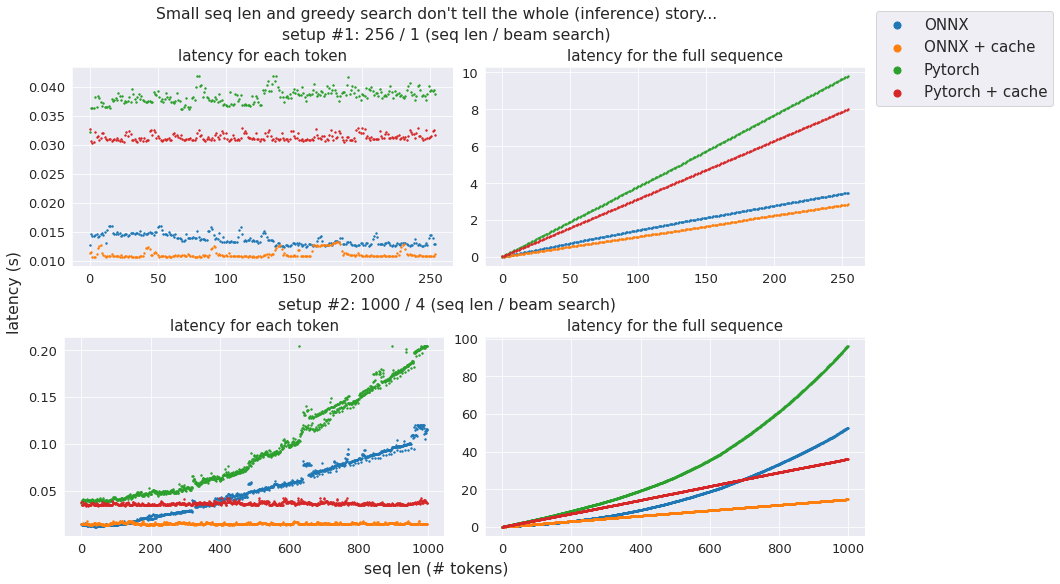

In [16]:
import seaborn as sns

sns.set_style("darkgrid")  # darkgrid, whitegrid, dark, white and ticks
plt.rc("axes", titlesize=15)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=13)  # fontsize of the tick labels
plt.rc("ytick", labelsize=13)  # fontsize of the tick labels
plt.rc("legend", fontsize=15)  # legend fontsize
plt.rc("font", size=13)  # controls default text sizes

colors = sns.color_palette("deep")
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
subfigs = fig.subfigures(nrows=2, ncols=1)

fig.supxlabel("seq len (# tokens)")
fig.supylabel("latency (s)")
fig.suptitle("Small seq len and greedy search don't tell the whole (inference) story...")
for row, (plot_name, timings) in enumerate(all_timings.items()):
    subfigs[row].suptitle(f"setup #{1+row}: {plot_name} (seq len / beam search)")
    axs = subfigs[row].subplots(nrows=1, ncols=2)
    for col, accumulated in enumerate([False, True]):
        plot_axis = axs[col]
        for index, (k, v) in enumerate(timings.items()):
            axis = range(len(v))
            color = colors[index]
            v = np.array(v)
            # remove extreme values
            p99 = np.percentile(v, 99)
            v[v>p99] = p99
            v = np.cumsum(v) if accumulated else v
            plot_axis.scatter(axis, v, label=k, s=2)

        title = f"latency for the full sequence" if accumulated else f"latency for each token"
        plot_axis.title.set_text(title)

# legend deduplication
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 1), loc="upper left", markerscale=5)
plt.show()

## Profiling model at the kernel level

Below we reload the decoder model with kernel profiling enabled.  
It will help us to understand on which part of the computation graph the GPU spends its time.  

The number of events that Onnx Runtime can save is limited to [1 million](https://github.com/microsoft/onnxruntime/blob/a4b5fa334aa939fb159bdc571ed3d56ca8d31fc7/onnxruntime/core/common/profiler.cc#L10).
It is not an issue as we have seen that timings per token are mostly stable, so having only n first token information don't change anything.

The main information it gives us is that 30% of the time is spent on matrix multiplication when caching is used.  
The rest of the time is spent on mostly memory bound operations:
* element-wise operations which require little computation (`add`, `mul`, `div`, etc.)
* copy pasting tensors `GPU` <-> `GPU` with little transformation in between (`transpose`, `concat`, `cast`, etc.)

It matches the information provided by both `nvidia-smi` and `Nvidia Nsight` (the GPU profiler from Nvidia): the GPU is under utilized.  
That's why we think that a tool like `TensorRT` which will perform aggressive kernel fusion, reducing time spent on memory bounded operations, is a good fit for autoregressive models. Unfortunately, so far we have issues to make it work with the `If` operator.

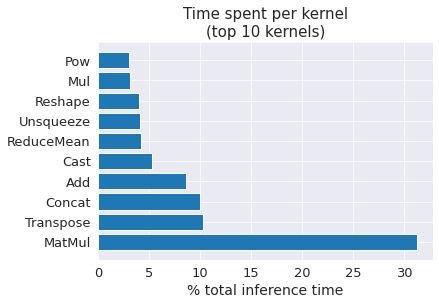

In [17]:
import operator
from collections import defaultdict


dec_onnx = create_model_for_provider(model_def.SerializeToString(), "CUDAExecutionProvider", enable_profiling=True, log_severity=3)
dec_onnx_binding: IOBinding = dec_onnx.io_binding()
_ = model_gen.generate(inputs=input_ids, max_length=10, num_beams=num_beam, min_length=10)
profile_name = dec_onnx.end_profiling()

with open(profile_name) as f:
    content = json.load(f)

op_timings = defaultdict(lambda: 0)
for c in content:
    if "op_name" not in c["args"]:
        continue
    op_name = c["args"]["op_name"]
    if op_name == "If":
        continue  # subgraph
    time_taken = c["dur"]
    op_timings[op_name] += time_taken

op_timings_filter = dict(sorted(op_timings.items(), key=operator.itemgetter(1), reverse=True)[:10])
total_kernel_timing = sum(op_timings.values())
op_timings_percent = {k: 100 * v / total_kernel_timing for k, v in op_timings_filter.items()}

plt.barh(list(op_timings_percent.keys()), list(op_timings_percent.values()))
plt.title("Time spent per kernel\n(top 10 kernels)")
plt.xlabel("% total inference time")
plt.show()